In [1]:
# Install prerequesite libraries
#!pip install torch torchvision transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.2 MB/s eta 0:00:00


# 1. Dataset

In [2]:
# The chosen 13 + 1 labels
label_map = {
    18: "love",
    11: "disgust",
    17: "joy",
    25: "sadness",
    13: "excitement",
    14: "fear",
    2: "anger",
    15: "gratitude",
    12: "embarrassment",
    4: "approval",
    10: "disapproval",
    7: "curiosity",
    23: "relief",
    27: "neutral"
}

In [3]:
# Load dataset
from datasets import load_dataset

# Load the GoEmotions dataset
dataset = load_dataset("go_emotions", "simplified")

# Access the train, validation, and test splits
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_dataset[0]

{'text': "My favourite food is anything I didn't have to cook myself.",
 'labels': [27],
 'id': 'eebbqej'}

### 1.1. Preprocess the dataset

In [7]:
from transformers import AutoTokenizer

# Replace 'bert-base-uncased' with the pre-trained model of your choice
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Max sequence length in dataset = 30
def preprocess_dataset(example):
    # Tokenize the input text and return the encoded result
    encoding = tokenizer(example["text"], truncation=True, padding="max_length", max_length=30)
    return encoding

# Filter selected labels to remove labels that are not in the label_map
def filter_selected_labels(example):
    for i in example["labels"]:
        if int(i) in label_map.keys():
            return True
    return False

from torch.utils.data import DataLoader

# fill statistics data while mapping
label_frequency_statistics = {}
text_data = [example["text"] for example in dataset["train"]]
text_lengths = [len(text.split()) for text in text_data]

# Preprocess the dataset
train_dataset = train_dataset.map(preprocess_dataset, batched=True)
val_dataset = val_dataset.map(preprocess_dataset, batched=True)
test_dataset = test_dataset.map(preprocess_dataset, batched=True)

# Set dataset format to PyTorch tensors
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

train_dataset = train_dataset.filter(filter_selected_labels)
val_dataset = val_dataset.filter(filter_selected_labels)
test_dataset = test_dataset.filter(filter_selected_labels)

labels_debug = []
def map_selected_labels(example):
  label = [label for label in example["labels"] if int(label) in label_map.keys()][0]
  labels_debug.append(label)
  example["labels"] = [label]

  label = int(label)
  text = example["text"]
  if label not in label_frequency_statistics:
    label_frequency_statistics[label] = text
  else:
    label_frequency_statistics[label] += " " + text
  
  return example

train_dataset = train_dataset.map(map_selected_labels)
val_dataset = val_dataset.map(map_selected_labels)
test_dataset = test_dataset.map(map_selected_labels)

#print(labels_debug)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Map:   0%|          | 0/31232 [00:00<?, ? examples/s]

Map:   0%|          | 0/3916 [00:00<?, ? examples/s]

Map:   0%|          | 0/3903 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31232 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3916 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3903 [00:00<?, ? examples/s]

Map:   0%|          | 0/31232 [00:00<?, ? examples/s]

Map:   0%|          | 0/3916 [00:00<?, ? examples/s]

Map:   0%|          | 0/3903 [00:00<?, ? examples/s]

In [6]:
# Verify we are only using existing classes
label_frequency_statistics.keys()

dict_keys([27, 2, 14, 15, 4, 12, 25, 17, 7, 10, 13, 18, 11, 23])

### Dataset analysis & charts

In [5]:
# Print first 100 labels in the dataset
print([int(label) for label in train_dataset["labels"][:100]])

[27, 27, 2, 14, 15, 27, 4, 27, 12, 15, 2, 27, 27, 12, 27, 27, 27, 2, 27, 25, 15, 27, 2, 27, 2, 17, 27, 25, 27, 15, 15, 27, 27, 7, 10, 27, 27, 27, 27, 27, 4, 27, 13, 10, 27, 27, 27, 15, 12, 27, 13, 27, 15, 27, 27, 27, 27, 27, 27, 13, 27, 13, 4, 25, 4, 27, 25, 15, 4, 27, 4, 27, 18, 4, 27, 7, 27, 7, 27, 10, 27, 27, 27, 7, 27, 15, 27, 27, 17, 27, 2, 2, 27, 27, 27, 4, 27, 2, 7, 2]


### 1.2 Prepare statistics data to be visualised

In [10]:
label_statistics = {label: 0 for label in label_map.values()}

# Gather statistics for piechart, barchart...
for example in train_dataset:
    for label_idx in example["labels"]:
        label = label_map[int(label_idx)]
        label_statistics[label] += 1

print("Label statistics:")
for label, count in label_statistics.items():
    print(f"{label}: {count}")

Label statistics:
love: 1830
disgust: 683
joy: 1227
sadness: 1179
excitement: 802
fear: 553
anger: 1567
gratitude: 2510
embarrassment: 276
approval: 2931
disapproval: 1929
curiosity: 2144
relief: 117
neutral: 13484


### 1.3 Visualise statistics

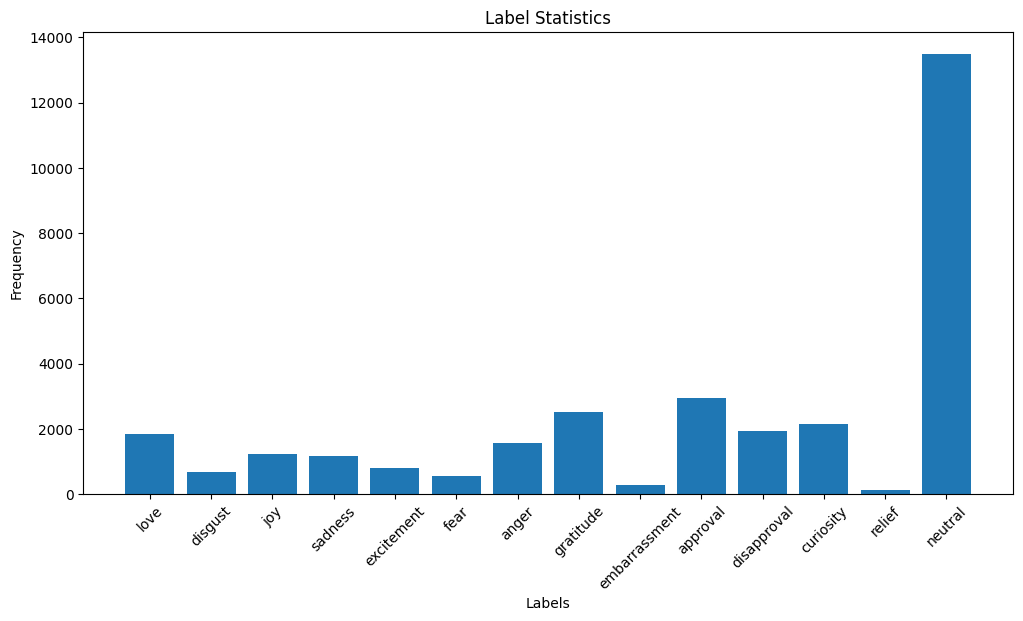

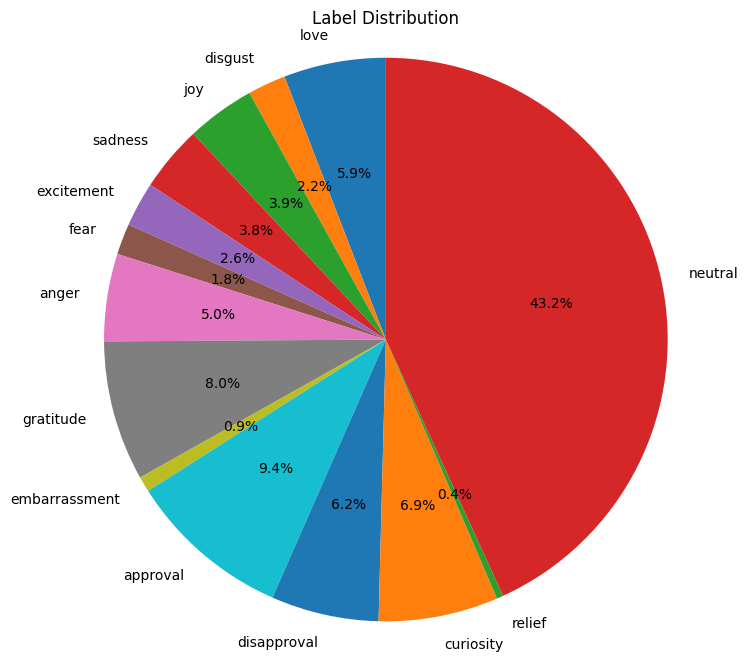

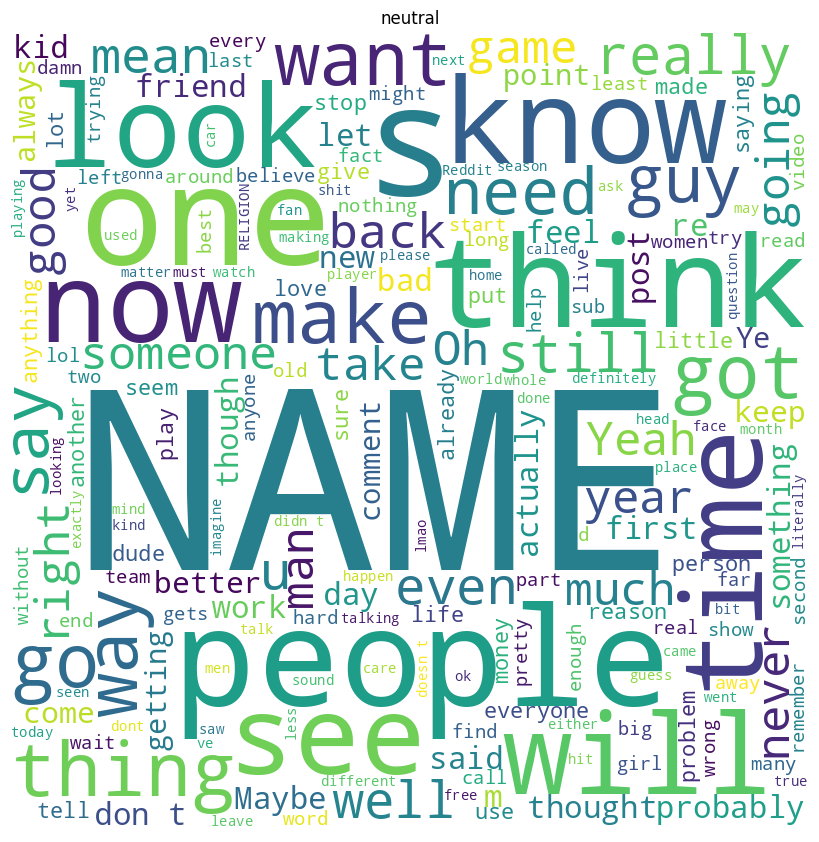

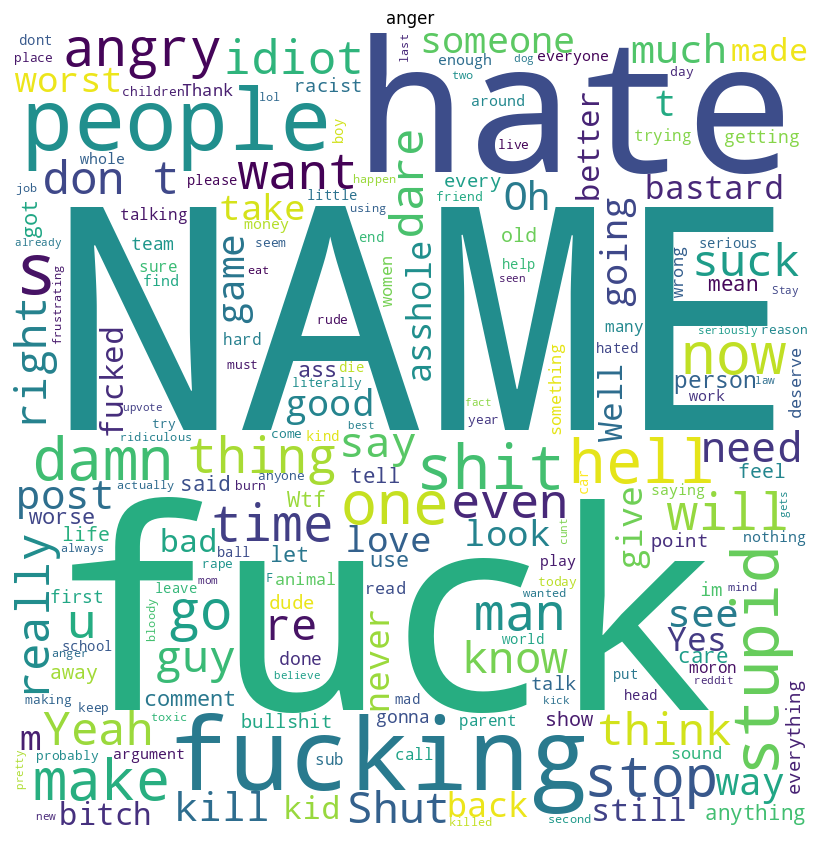

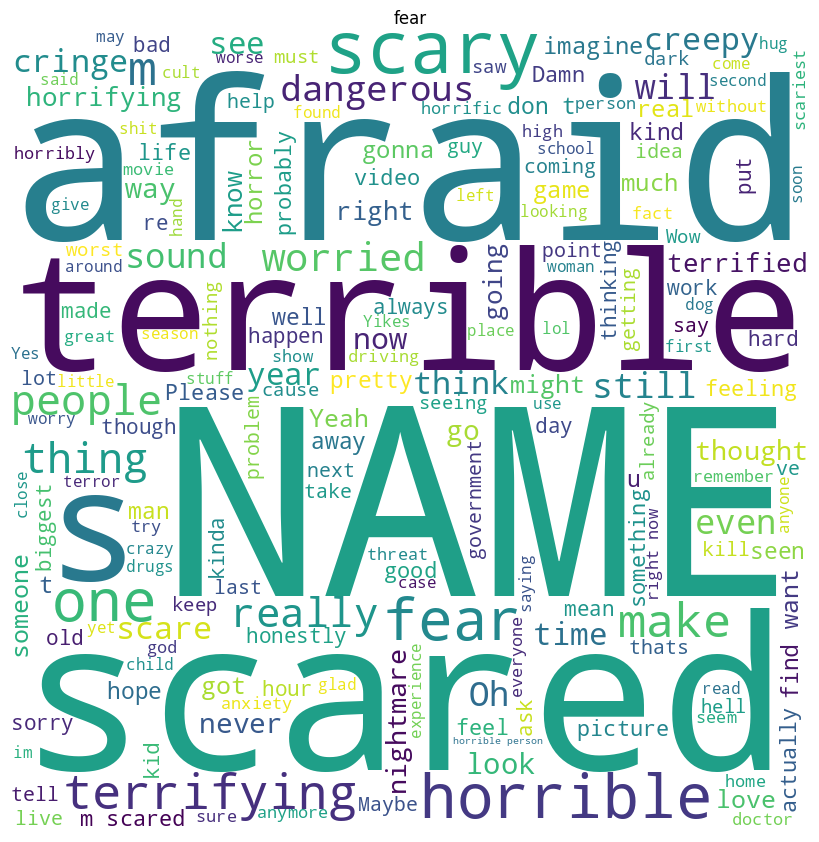

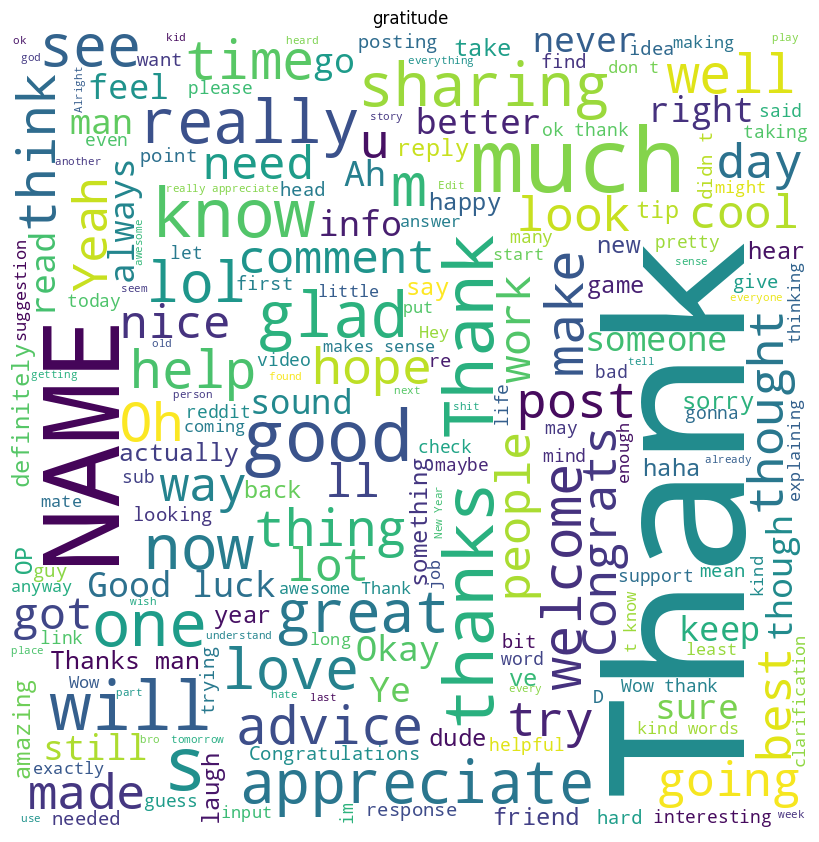

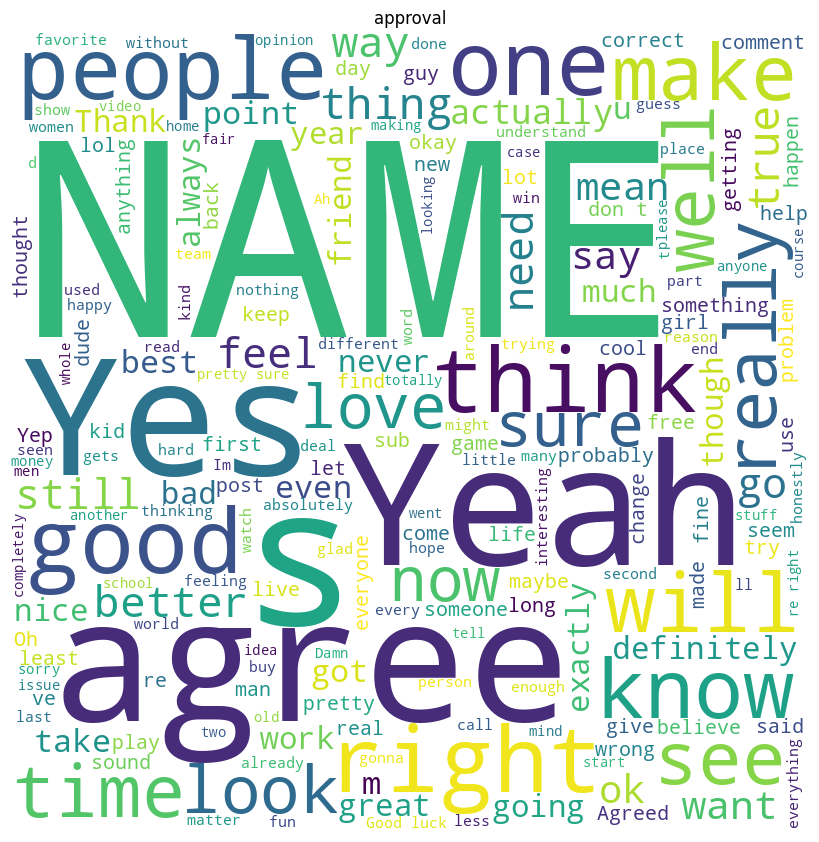

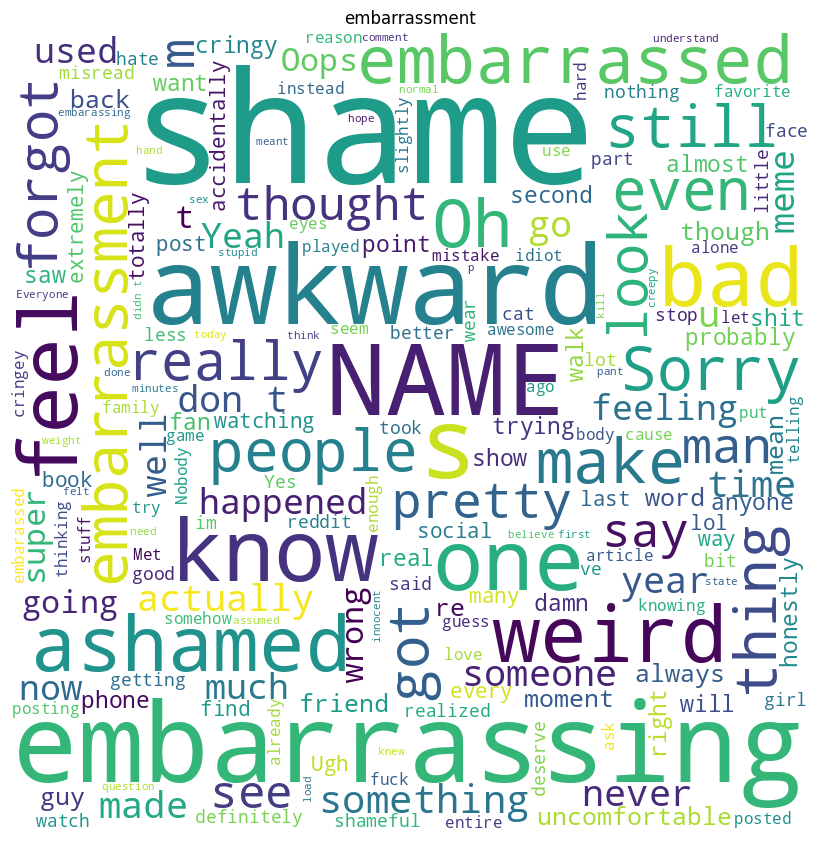

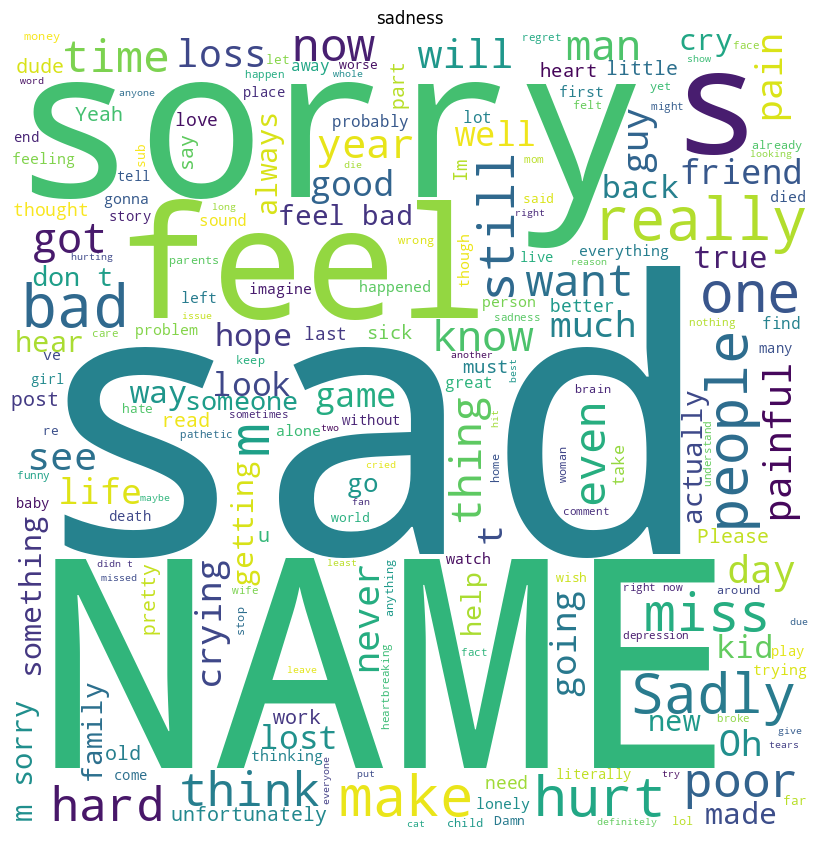

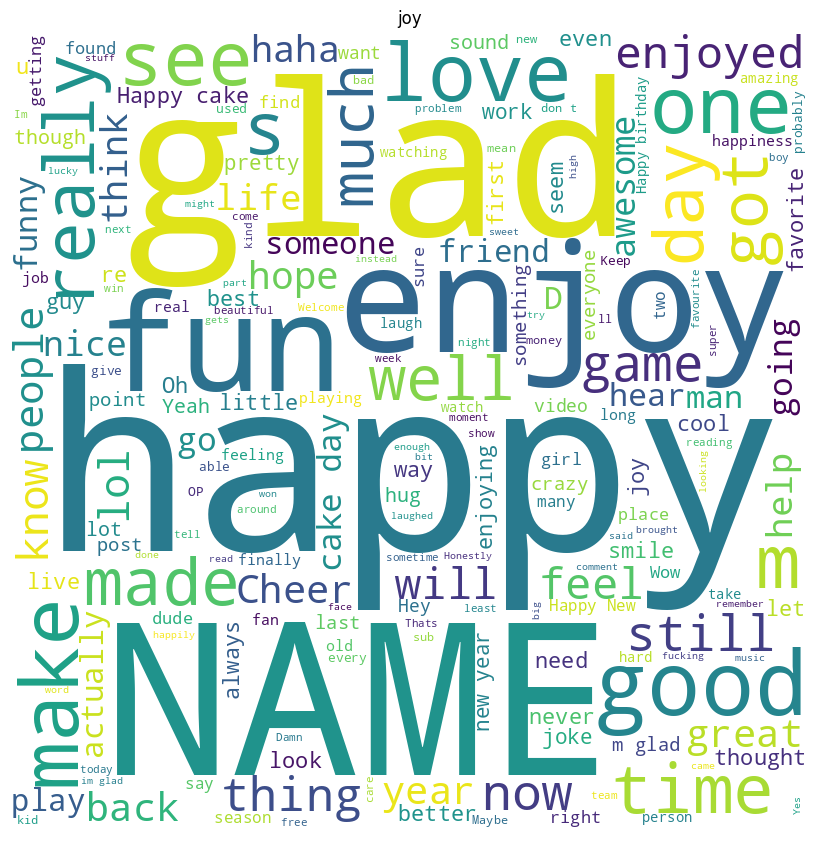

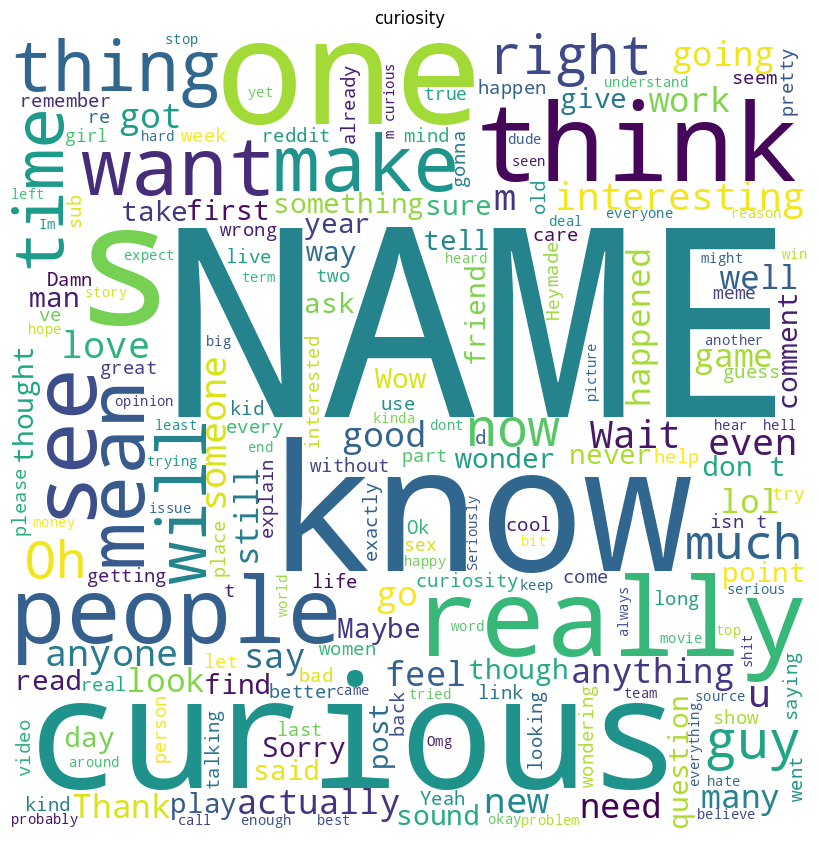

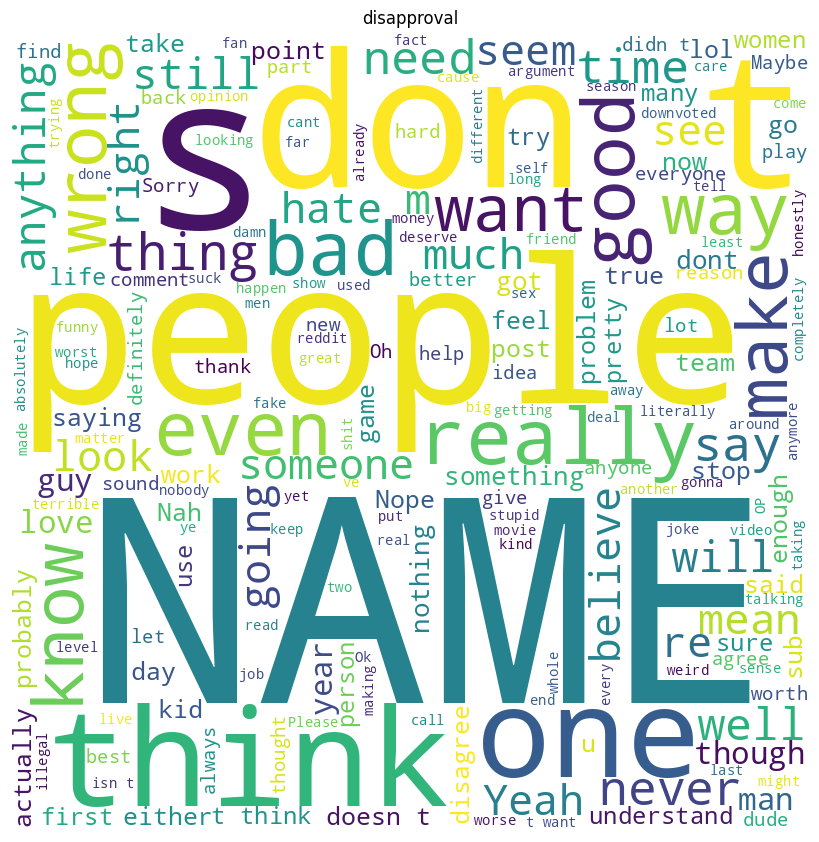

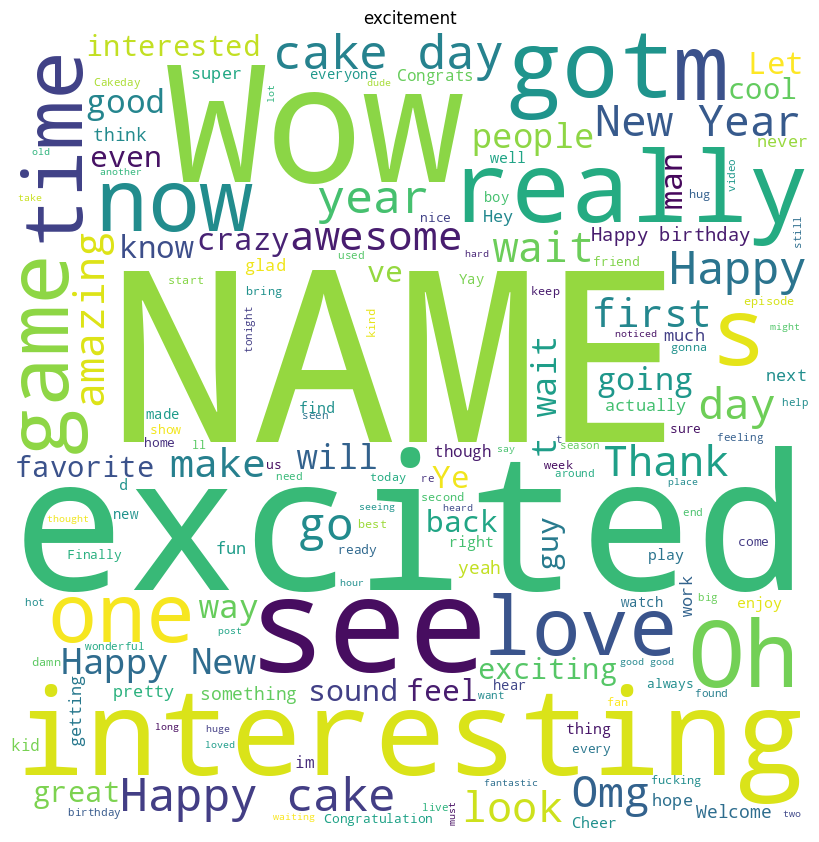

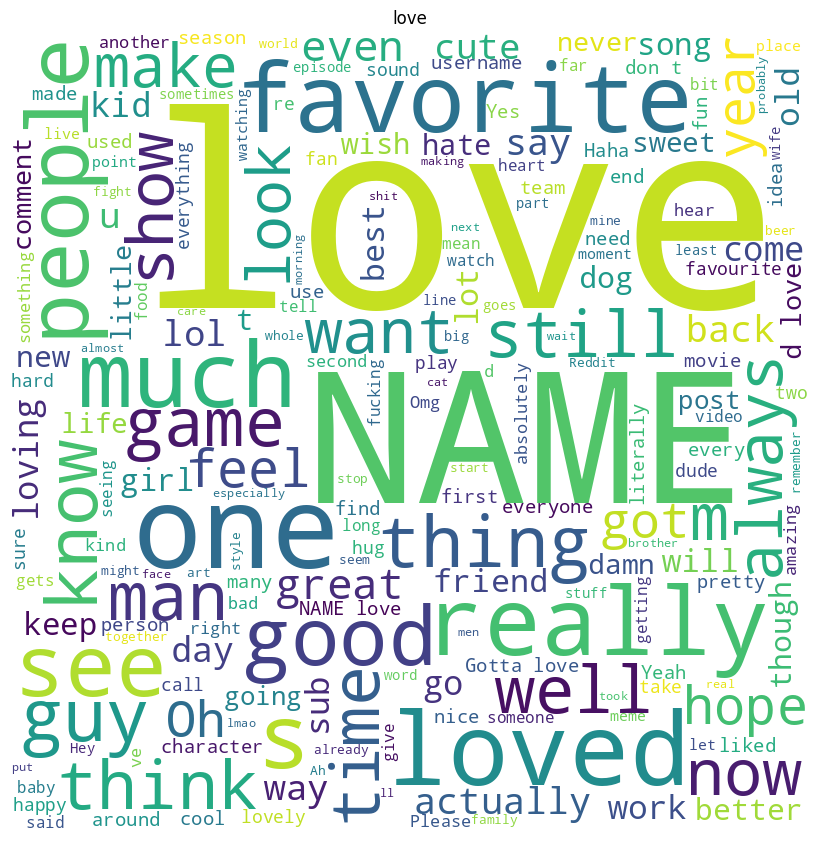

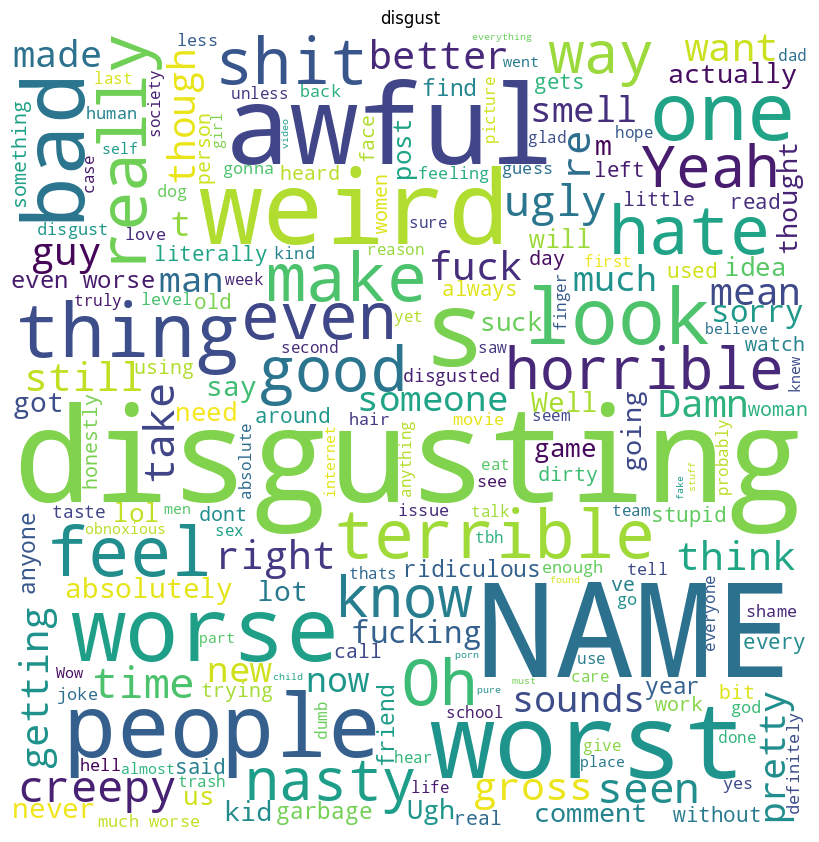

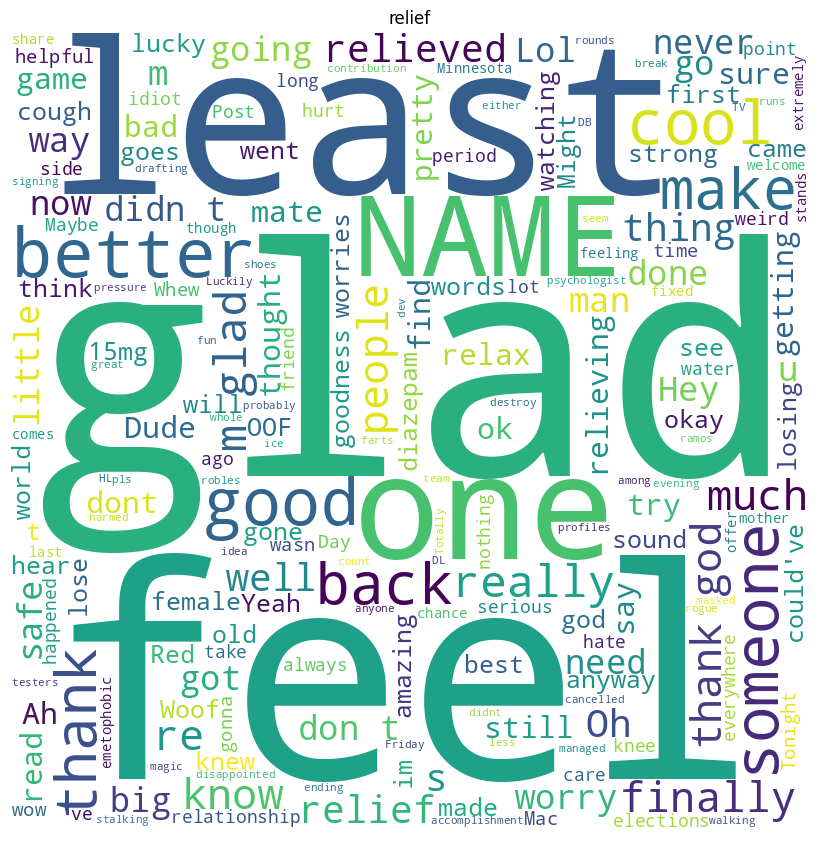

In [11]:
import matplotlib.pyplot as plt

# Bar chart for label statistics
plt.figure(figsize=(12, 6))
plt.bar(label_statistics.keys(), label_statistics.values())
plt.xlabel("Labels")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.title("Label Statistics")
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(label_statistics.values(), labels=label_statistics.keys(), autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Label Distribution")
plt.show()

from wordcloud import WordCloud

# Visualise label_frequency_statistics in a worldcloud
for label, text in label_frequency_statistics.items():
    wordcloud = WordCloud(width=800, height=800, background_color="white", min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(label_map[label])
    plt.show()


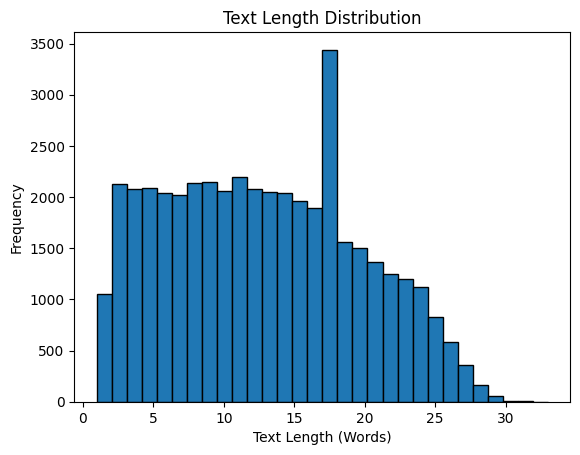

average text length: 12.840175074867542


In [12]:
# Text lengths histogram
plt.hist(text_lengths, bins=30, edgecolor="black")
plt.xlabel("Text Length (Words)")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()

avg_text_length = sum(text_lengths) / len(text_lengths)
print(f"average text length: {avg_text_length}")

---
## 2. Train

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
from transformers import AutoModelForSequenceClassification

# Replace 'bert-base-uncased' with the pre-trained model of your choice
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=28)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
from transformers import Trainer, TrainingArguments

# Set training arguments
training_args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    logging_dir="logs",
    learning_rate=5e-5,
    weight_decay=0.01,
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=2928, training_loss=0.8179451363985656, metrics={'train_runtime': 726.9338, 'train_samples_per_second': 128.892, 'train_steps_per_second': 4.028, 'total_flos': 1444816898334720.0, 'train_loss': 0.8179451363985656, 'epoch': 3.0})

In [ ]:
from datasets import load_metric
import numpy as np

accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels),
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted"),
    }

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Evaluate the model on the validation dataset
val_results = trainer.evaluate()
print("Validation results:", val_results)

# Evaluate the model on the test dataset
trainer.eval_dataset = test_dataset
test_results = trainer.evaluate()
print("Test results:", test_results)

Trainer is attempting to log a value of "{'accuracy': 0.6567926455566905}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6545189532262219}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Validation results: {'eval_loss': 1.0955569744110107, 'eval_accuracy': {'accuracy': 0.6567926455566905}, 'eval_f1': {'f1': 0.6545189532262219}, 'eval_runtime': 7.7706, 'eval_samples_per_second': 503.953, 'eval_steps_per_second': 15.829}


Trainer is attempting to log a value of "{'accuracy': 0.6707660773763772}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6717156307223772}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Test results: {'eval_loss': 1.0385491847991943, 'eval_accuracy': {'accuracy': 0.6707660773763772}, 'eval_f1': {'f1': 0.6717156307223772}, 'eval_runtime': 7.254, 'eval_samples_per_second': 538.046, 'eval_steps_per_second': 16.818}


In [ ]:
output_dir = "."
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json',
 './tokenizer.json')